In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd
from scipy.stats import theilslopes
sn.set_context('talk')

# Check significance

In an e-mail received 19/07/2016 at 17:20, Don pointed out a couple of TOC plots on my [trends map](https://www.googledrive.com/host/0BximeC_RweaeZlpSTWNrTHRyVG8) where he was surprised that the estimated trend was deemed insignificant:

 * Little Woodford (site code X15:1C1-093)
 * Partridge (station code X15:ME-9999)
 
Checking this will provide a useful test of my trend analysis code.

To make the test as independent as possible, I've started off by extracting TOC data for these two sites using the manual interface for RESA2. This method of accessing the database is completely separate to that used by my trends code, so it'll be interesting to see whether I get the same results!

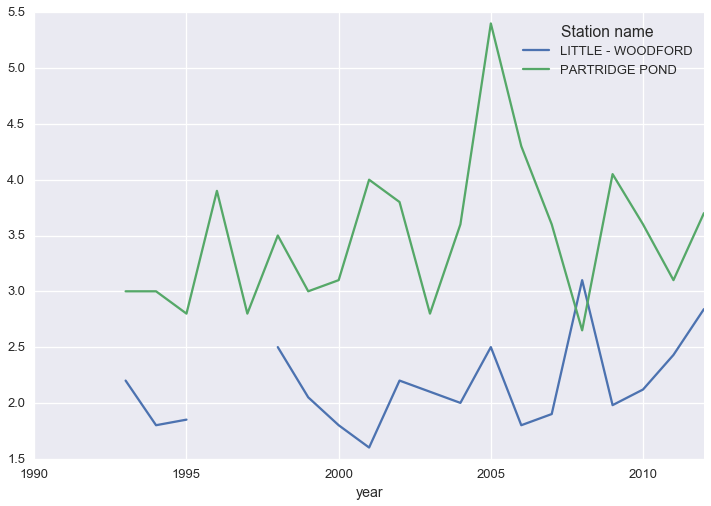

Station name,LITTLE - WOODFORD,PARTRIDGE POND
count,18.000000,20.000000
mean,2.153889,3.485000
std,0.390628,0.664138
min,1.600000,2.650000
25%,1.862500,3.000000
50%,2.075000,3.550000
75%,2.372500,3.825000
max,3.100000,5.400000


In [2]:
# Read RESA2 export, calculate annual medians and plot

# Input file
in_xlsx = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
           r'\Data\TOC_Little_Woodford_Partridge.xlsx')
df = pd.read_excel(in_xlsx, sheetname='DATA')

# Pivot
df = df.pivot(index='Date', columns='Station name', values='TOC')
df.reset_index(inplace=True)

# Calculate year
df['year'] = df['Date'].apply(lambda x: x.year)

# Take median in each year
grpd = df.groupby(['year',])
df = grpd.aggregate('median')

# Plot
df.plot(figsize=(12, 8))
plt.show()

# Print summary stats
df.describe()

These plots and summary statistics are identical to the ones given on my web map (with the exception that, for plotting, the web map linearly interpolates over data gaps, so the break in the line for Little Woodford is not presented). This is a good start. 

The next step is to estimate the Theil-Sen slope. It would also be useful to plot the 95% confidence interval around the line, as this should make it easier to see whether a trend ought to be identified as significant or not. However, a little surprisingly, it seems there is no standard way of estimating confidence intervals for Theil-Sen regressions. This is because the Theil-Sen method is strictly a way of estimating the **slope** of the regression line, but not the intercept (see e.g. [here](http://stats.stackexchange.com/questions/50587/intercept-calculation-in-theil-sen-estimator)). 

A number of intercept estimators have been proposed previously (e.g. [here](http://www.stat.ncsu.edu/information/library/mimeo.archive/ISMS_1987_1690R.pdf)). For the median regression, which is what I've plotted on my web map, SciPy uses the [Conover Estimator](http://vsp.pnnl.gov/help/Vsample/Nonparametric_Estimate_of_Trend.htm) to calculate the intercept

$$\beta_{median} = y_{median} - M_{median} * x_{median}$$

where $\beta$ is the intercept and $M$ is the slope calculated using the Theil-Sen method. Although I can't find many references for constructing confidence intervals for this type of regression, presumably I can just generalise the above formula to estimate slopes and intercepts for any percentile, $p$

$$\beta_{p} = y_{p} - M_{p} * x_{p}$$

It's worth a try, anyway.

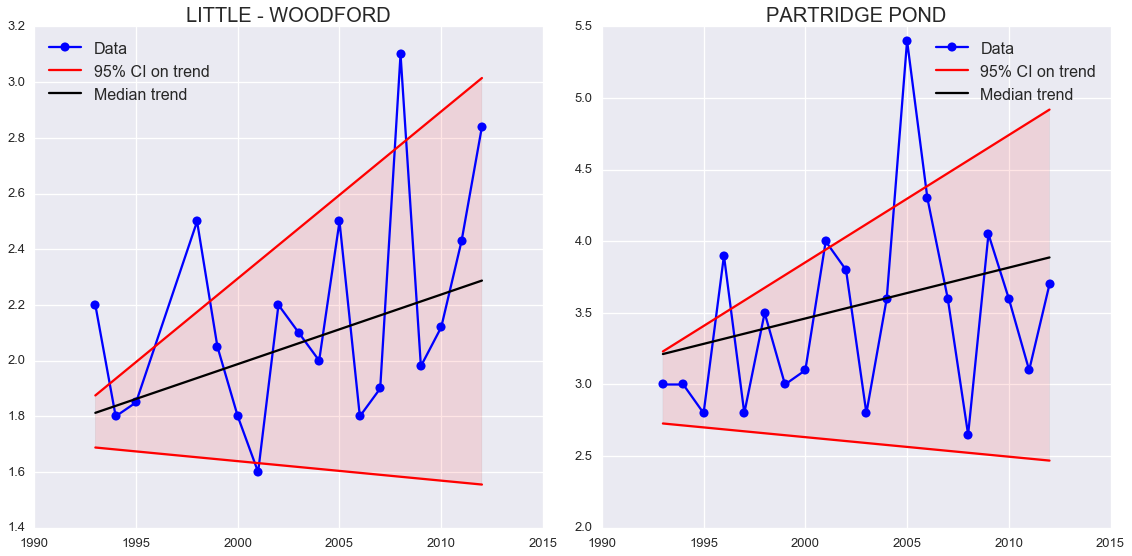

In [3]:
# Theil-Sen regression

# Set up plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Loop over sites
for idx, site in enumerate(['LITTLE - WOODFORD', 'PARTRIDGE POND']):
    # Get data
    df2 = df[site].reset_index()
    
    # Drop NaNs
    df2.dropna(how='any', inplace='True')

    # Get quantiles
    qdf = df2.quantile([0.025, 0.975])
    y_2_5 = qdf.ix[0.025, site]
    x_2_5 = qdf.ix[0.025, 'year']
    y_97_5 = qdf.ix[0.975, site]
    x_97_5 = qdf.ix[0.975, 'year']
    
    # Theil-Sen regression
    slp_50, icpt_50, slp_lb, slp_ub = theilslopes(df2[site].values, 
                                                  df2['year'].values, 0.95)
    
    # Calculate CI for intercepts
    icpt_lb = y_2_5 - (slp_lb * x_2_5)
    icpt_ub = y_97_5 - (slp_ub * x_97_5)
    
    # Plot
    # Data
    axes[idx].plot(df2['year'], df2[site], 'bo-', label='Data')
    
    # Lower and upper CIs
    axes[idx].plot(df2['year'], 
                   slp_lb * df2['year'] + icpt_lb,
                   'r-', label='')
    
    axes[idx].plot(df2['year'], 
                   slp_ub * df2['year'] + icpt_ub,
                   'r-', label='95% CI on trend')
    
    axes[idx].fill_between(df2['year'],
                           slp_lb * df2['year'] + icpt_lb,
                           slp_ub * df2['year'] + icpt_ub, 
                           facecolor='red',
                           alpha=0.1)
    
    # Median 
    axes[idx].plot(df2['year'], 
                   slp_50 * df2['year'] + icpt_50,
                   'k-', label='Median trend')
    
    axes[idx].legend(loc='best', fontsize=16)
    axes[idx].set_title(site, fontsize=20)
    
plt.tight_layout()
plt.show()

These plots illustrate why the trend is *not* considered to be significant: although in both cases the **median** trend implies quite a strong relationship (i.e. the effect size is large), the associated **uncertainty** is sufficiently big that we can't rule out the trend being zero (or even slightly negative) at the 95% confidence level.

It would be relatively easy to modify the code for my map to include these confidence intervals on the plots in the pop-up windows for each station. My main reason for not doing this originally is that the Mann-Kendall and Theil-Sen tests are slightly different, so (I think) it would be possible to have contradictory "edge cases" where, for the same dataset, the M-K test returns "significant" whereas the Theil-Sen estimator returns "insignificant" (and vice versa). Of the two approaches, M-K is well accepted and widely used as a test for trend significance, whereas I can't find much information at all regarding constructing confidence intervals for the Theil-Sen estimator. The method I've used above seems reasonable to me, but I've basically made it up and it would be nice to have a reference of some kind to confirm my approach before including it on the map.